In [1]:
import sys
from pathlib import Path

# Sobe até encontrar a raiz do projeto 'datathon'
ROOT_DIR = Path.cwd()
while ROOT_DIR.name != "datathon" and ROOT_DIR != ROOT_DIR.parent:
    ROOT_DIR = ROOT_DIR.parent

# Adiciona a raiz ao sys.path
sys.path.append(str(ROOT_DIR))

# Agora o import funciona
from app.utils.db_path import get_db_path

In [2]:
print("📁 Caminho do banco:", get_db_path())

📁 Caminho do banco: d:\0Viviana\1 FIAP\5 fase\datathon\app\data\extraidos\dados.db


In [66]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import sqlite3
from pathlib import Path
import os

In [97]:
def detectar_drift_vaga(df_merged):
    # 1. Verificar dados faltantes
    faltantes = df_merged.isnull().mean()
    campos_criticos = faltantes[faltantes > 0.3].index.tolist()

    # 2. Extrair perfil do candidato
    df_merged["perfil_candidato"] = df_merged["informacoes_profissionais_conhecimentos_tecnicos"].apply(
        lambda x: ','.join(x) if isinstance(x, list) else str(x)
    )

    # 3. Classificar tipo de vaga aplicada com base no título da vaga
    def classificar_tipo_vaga(titulo):
        titulo = str(titulo).lower()

        if any(p in titulo for p in [
            "desenvolvedor", "dev", "backend", "frontend", "full stack", "java", "angular", "nodejs",
            "programador", "delphi", "oracle", "cloud", "infra", "noc", "helpdesk", "redes", "telecom",
            "segurança da informação", "sistemas", "gestão de acessos", "consultor de novas tecnologias",
            "forms", "engenheiro", "tech", "ti", "software", "devops"
        ]):
            return "tecnologia"

        elif any(p in titulo for p in ["sap", "abap", "sd", "mm", "consultor sap"]):
            return "sap"

        elif any(p in titulo for p in [
            "dados", "etl", "data engineer", "analista de negócio", "analista de processos", "pmo",
            "bi", "analytics", "estoque"
        ]):
            return "dados/bi"

        elif any(p in titulo for p in [
            "recrutamento", "seleção", "expansao", "vendedor", "assistente administrativo", "controlador de acesso",
            "rh", "recursos humanos", "proxxi", "analista de rh", "assistente adm"
        ]):
            return "administrativo/rh"

        elif any(p in titulo for p in [
            "gerente de projeto", "gerente de projetos", "homologador", "analista de requisitos",
            "analista de testes", "teste", "coordenador", "analistas", "business analyst"
        ]):
            return "gestão/projetos"

        else:
            return "outros"
        
    # 4. Aplicar classificação
    df_merged["tipo_vaga_aplicada"] = df_merged["informacoes_basicas_titulo_vaga"].apply(classificar_tipo_vaga)
    df_merged["tipo_perfil_candidato"] = df_merged["perfil_candidato"].apply(classificar_tipo_vaga)

    # 5. Detectar drift
    df_merged["drift_detectado"] = df_merged["tipo_vaga_aplicada"] != df_merged["tipo_perfil_candidato"]

    # 6. Retornar insights
    return {
        "drift_total": int(df_merged["drift_detectado"].sum()),
        "total_candidatos": len(df_merged),
        "campos_faltantes_criticos": campos_criticos,
        "candidatos_com_drift": df_merged[df_merged["drift_detectado"]][[
            "informacoes_pessoais_nome",
            "informacoes_basicas_titulo_vaga",
            "tipo_vaga_aplicada",
            "tipo_perfil_candidato"
        ]]
    }

In [98]:
# Caminho correto para o banco
db_path = get_db_path()
db_path

'd:\\0Viviana\\1 FIAP\\5 fase\\datathon\\app\\data\\extraidos\\dados.db'

In [99]:
conn = sqlite3.connect(db_path)

In [100]:
df_applicants = pd.read_sql_query("SELECT * FROM applicants", conn)
df_prospects = pd.read_sql_query("SELECT * FROM prospects", conn)
df_vagas = pd.read_sql_query("SELECT * FROM vagas", conn)

In [101]:
# Join entre candidatos e prospects
df_merged = df_applicants.merge(df_prospects, on="codigo", how="left")

# Join com as vagas
df_merged = df_merged.merge(df_vagas, left_on="codigo_vaga", right_on="codigo", how="left", suffixes=('', '_vaga'))

In [102]:
drift = detectar_drift_vaga(df_merged)

In [103]:
df_outros = df_merged [df_merged ["tipo_vaga_aplicada"] == "outros"]
print(df_outros["informacoes_basicas_titulo_vaga"].value_counts().head(20))

informacoes_basicas_titulo_vaga
Scrum Master                                  128
QA                                             89
Analista de Suporte                            76
Product Owner                                  62
Project Manager                                62
Suporte técnico                                33
Cobol Senior                                   32
Quality Assurance Pleno e Senior               25
CONSULTOR OPERAÇÕES DE SEGURANÇA - SR          25
Adm Windows - Inglês fluente - 20216851560     25
Analista de projetes pleno                     25
Perfil UX/UI Designer                          25
Analista de QA - PL                            25
Datastage Nível Pl. / Sr.Porto Seguro          25
AGILE MASTER pleno / sênior                    25
analista seo                                   25
Analista de integrações                        25
Analista Sênior de GRC                         25
Quality Assurance Pleno e Sênior               25
Consultor de Proje

In [104]:
print("🔍 Drift total detectado:", drift["drift_total"])
print("📊 Total de candidatos analisados:", drift["total_candidatos"])
print("⚠️ Campos com muitos dados faltantes:", drift["campos_faltantes_criticos"])

🔍 Drift total detectado: 35089
📊 Total de candidatos analisados: 64114
⚠️ Campos com muitos dados faltantes: ['formacao_e_idiomas_instituicao_ensino_superior', 'formacao_e_idiomas_cursos', 'formacao_e_idiomas_ano_conclusao', 'informacoes_pessoais_download_cv', 'informacoes_profissionais_qualificacoes', 'informacoes_profissionais_experiencias', 'formacao_e_idiomas_outro_curso', 'cargo_atual_id_ibrati', 'cargo_atual_email_corporativo', 'cargo_atual_cargo_atual', 'cargo_atual_projeto_atual', 'cargo_atual_cliente', 'cargo_atual_unidade', 'cargo_atual_data_admissao', 'cargo_atual_data_ultima_promocao', 'cargo_atual_nome_superior_imediato', 'cargo_atual_email_superior_imediato', 'informacoes_basicas_nome', 'informacoes_basicas_telefone', 'perfil_vaga_equipamentos_necessarios', 'informacoes_basicas_data_inicial', 'informacoes_basicas_data_final', 'perfil_vaga_habilidades_comportamentais_necessarias', 'informacoes_basicas_nome_substituto']


In [105]:
def gerar_relatorio_drift(drift_resultado):
    total = drift_resultado["total_candidatos"]
    drift = drift_resultado["drift_total"]
    campos = drift_resultado["campos_faltantes_criticos"]
    candidatos = drift_resultado["candidatos_com_drift"]

    relatorio = f"""
📊 RELATÓRIO DE DRIFT DE PERFIL

🔍 Total de candidatos analisados: {total}
⚠️ Candidatos com incompatibilidade de perfil: {drift}
📉 Campos com dados faltantes críticos (>30%): {', '.join(campos) if campos else 'Nenhum'}

📋 Candidatos com drift detectado:
"""

    for _, row in candidatos.iterrows():
        relatorio += f"- {row['informacoes_pessoais_nome']}: aplicou para vaga de '{row['tipo_vaga_aplicada']}', perfil identificado como '{row['tipo_perfil_candidato']}'\n"

    return relatorio

In [106]:
print(gerar_relatorio_drift(drift))


📊 RELATÓRIO DE DRIFT DE PERFIL

🔍 Total de candidatos analisados: 64114
⚠️ Candidatos com incompatibilidade de perfil: 35089
📉 Campos com dados faltantes críticos (>30%): formacao_e_idiomas_instituicao_ensino_superior, formacao_e_idiomas_cursos, formacao_e_idiomas_ano_conclusao, informacoes_pessoais_download_cv, informacoes_profissionais_qualificacoes, informacoes_profissionais_experiencias, formacao_e_idiomas_outro_curso, cargo_atual_id_ibrati, cargo_atual_email_corporativo, cargo_atual_cargo_atual, cargo_atual_projeto_atual, cargo_atual_cliente, cargo_atual_unidade, cargo_atual_data_admissao, cargo_atual_data_ultima_promocao, cargo_atual_nome_superior_imediato, cargo_atual_email_superior_imediato, informacoes_basicas_nome, informacoes_basicas_telefone, perfil_vaga_equipamentos_necessarios, informacoes_basicas_data_inicial, informacoes_basicas_data_final, perfil_vaga_habilidades_comportamentais_necessarias, informacoes_basicas_nome_substituto

📋 Candidatos com drift detectado:
- Caro

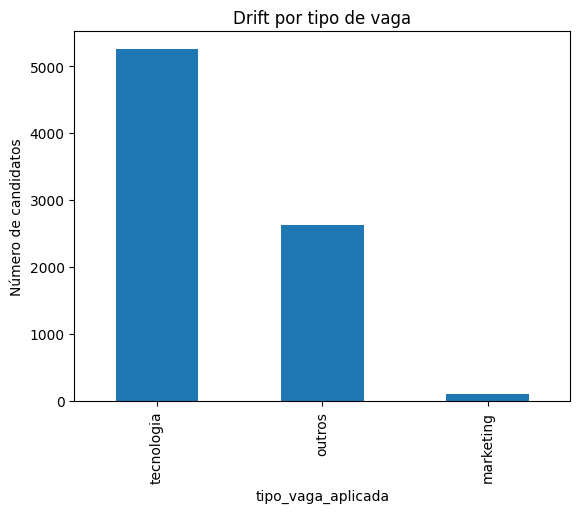

In [61]:
import matplotlib.pyplot as plt

df_drift = drift["candidatos_com_drift"]
df_drift["tipo_vaga_aplicada"].value_counts().plot(kind="bar", title="Drift por tipo de vaga")
plt.ylabel("Número de candidatos")
plt.show()